In [1]:
%matplotlib inline
import pandas as pd

from darts.models import TCNModel
import darts.utils.timeseries_generation as tg
from darts.utils.likelihood_models import GaussianLikelihood
from darts.datasets import EnergyDataset
from darts.utils.missing_values import fill_missing_values
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

import matplotlib.pyplot as plt

/home/dev/miniconda3/envs/pf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


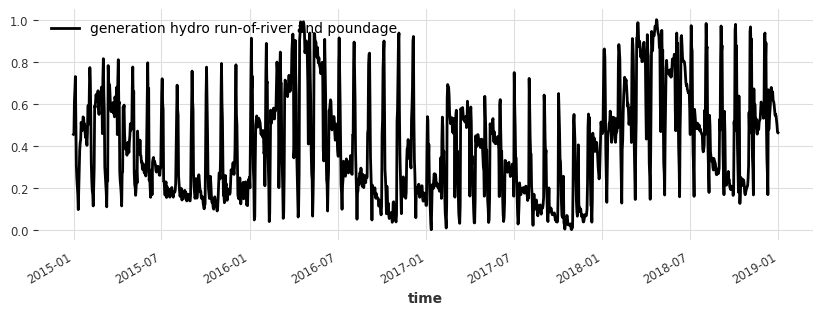

In [2]:
df3 = EnergyDataset().load().pd_dataframe()
df3_day_avg = (
    df3.groupby(df3.index.astype(str).str.split(" ").str[0]).mean().reset_index()
)
series_en = fill_missing_values(
    TimeSeries.from_dataframe(
        df3_day_avg, "time", ["generation hydro run-of-river and poundage"]
    ),
    "auto",
)

# scale
scaler_en = Scaler()
series_en_transformed = scaler_en.fit_transform(series_en)
train_en_transformed, val_en_transformed = series_en_transformed.split_after(
    pd.Timestamp("20170901")
)

# add the day as a covariate
day_series = datetime_attribute_timeseries(
    series_en_transformed, attribute="day", one_hot=True
)
scaler_day = Scaler()
day_series = scaler_day.fit_transform(day_series)
train_day, val_day = day_series.split_after(pd.Timestamp("20170901"))

plt.figure(figsize=(10, 3))
series_en_transformed.plot()

In [3]:
deeptcn = TCNModel(
    dropout=0.2,
    batch_size=32,
    n_epochs=20,
    optimizer_kwargs={"lr": 1e-3},
    random_state=0,
    input_chunk_length=300,
    output_chunk_length=30,
    kernel_size=3,
    num_filters=4,
    likelihood=GaussianLikelihood(),
)

deeptcn.fit(series=train_en_transformed, past_covariates=train_day, verbose=True)

Epoch 19: 100%|██████████| 21/21 [00:00<00:00, 171.18it/s, train_loss=-.391]  


TCNModel(kernel_size=3, num_filters=4, num_layers=None, dilation_base=2, weight_norm=False, dropout=0.2, batch_size=32, n_epochs=20, optimizer_kwargs={'lr': 0.001}, random_state=0, input_chunk_length=300, output_chunk_length=30, likelihood=<darts.utils.likelihood_models.GaussianLikelihood object at 0x7fe90452b850>)

In [4]:
backtest_en = deeptcn.historical_forecasts(
    series=series_en_transformed,
    past_covariates=day_series,
    num_samples=50,
    start=0.7,
    forecast_horizon=30,
    stride=5,
    retrain=False,
    verbose=True,
)

  0%|          | 0/83 [00:00<?, ?it/s]

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 321.55it/s]

  8%|▊         | 7/83 [00:00<00:01, 67.55it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 315.67it/s]

 18%|█▊        | 15/83 [00:00<00:00, 71.98it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 312.08it/s]


 28%|██▊       | 23/83 [00:00<00:00, 73.27it/s]

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 314.34it/s]

 37%|███▋      | 31/83 [00:00<00:00, 73.72it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 310.14it/s]

 47%|████▋     | 39/83 [00:00<00:00, 74.03it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 317.63it/s]

 57%|█████▋    | 47/83 [00:00<00:00, 73.46it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 320.84it/s]

 66%|██████▋   | 55/83 [00:00<00:00, 74.15it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 317.56it/s]

 76%|███████▌  | 63/83 [00:00<00:00, 74.60it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 245.27it/s]

 86%|████████▌ | 71/83 [00:00<00:00, 73.97it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 310.25it/s]

 95%|█████████▌| 79/83 [00:01<00:00, 73.72it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 312.96it/s]

100%|██████████| 83/83 [00:01<00:00, 73.59it/s]

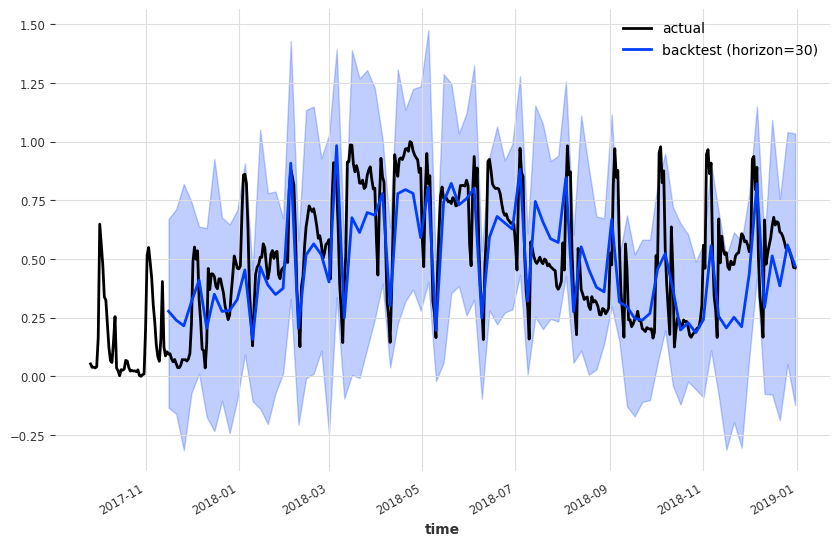

In [5]:
plt.figure(figsize=(10, 6))
series_en_transformed[1000:].plot(label="actual")
backtest_en.plot(label="backtest (horizon=30)", low_quantile=0.01, high_quantile=0.99)
plt.legend()